# Data analysis of speckle_15 data

Mahmoud Morsy, July 2020

Contributed by Antoine Wojdyla

data is available at https://drive.google.com/drive/folders/1ybLxPm0LxCeDPnH3ShTo3BZYoZTYK9Vw?usp=sharing

# Loading data

In [1]:
folder = "/Volumes/GoogleDrive/.shortcut-targets-by-id/1Nje49I-FUO7__sonSiK2EQSrheuPEm-e/Supreme/data/supreme-15/"

### loading an image

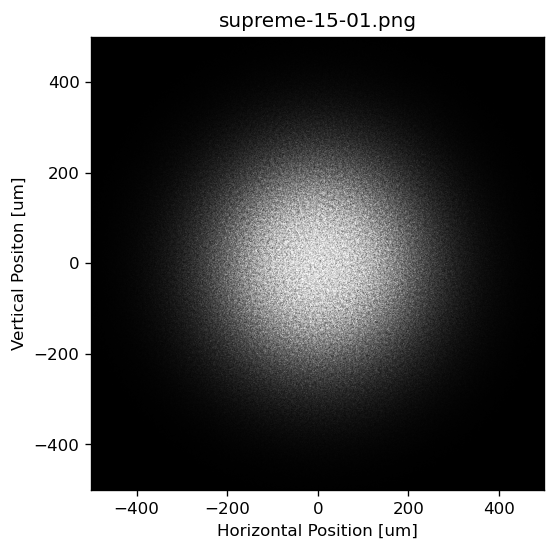

In [2]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp, warp_polar

dx_m = 1e-6  #pixel size in meter
Dx_m = 1e-3      #image full size

x_m = np.linspace(-Dx_m/2, Dx_m/2, int(np.floor(Dx_m/dx_m) + 1))

real_axis = x_m
fs = 1/(real_axis[1]-real_axis[0])
Nfft=len(real_axis)
df = fs/Nfft
f_cpm = np.linspace(0,(fs-df),Nfft) - (fs-np.mod(Nfft,2)*df)/2 # Do not understand the calculations here.

i_f = 1
filename = "supreme-15-%02.0f"%i_f+".png"

filepath = folder + filename
img = np.asarray(Image.open(filepath))

extent = (-Dx_m/2 * 1e6, +Dx_m/2 * 1e6, -Dx_m/2 * 1e6, +Dx_m/2 * 1e6)
fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.imshow(img, extent=extent, cmap = 'gray')
plt.xlabel('Horizontal Position [um]')
plt.ylabel('Vertical Positon [um]')
plt.title(filename)
plt.show()

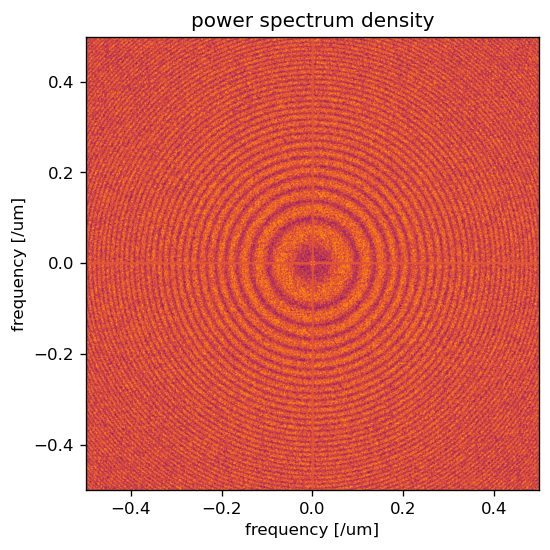

In [3]:
# Fourier Transform
IMG = np.fft.fftshift(np.fft.fft2(img))

IMG_d = IMG
IMG_d[498:503,:]=np.mean(abs(IMG))
IMG_d[:,498:503]=np.mean(abs(IMG))
Df_cpm = f_cpm[-1]-f_cpm[0]
extent = (-Df_cpm/2 * 1e-6, +Df_cpm/2 * 1e-6, -Df_cpm/2 * 1e-6, +Df_cpm/2 * 1e-6) 
fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.imshow(np.abs(IMG_d)**0.1, extent=extent, cmap = 'inferno')
plt.title('power spectrum density')
plt.xlabel('frequency [/um]')
plt.ylabel('frequency [/um]')
plt.show()

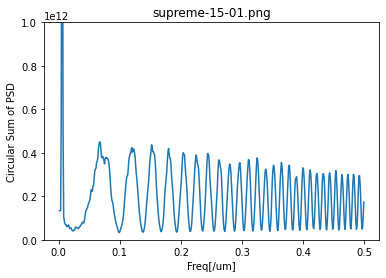

In [4]:
CIRCSUM = np.sum(warp_polar(np.abs(IMG)**2), 0)
plt.plot(f_cpm[501:]*1e-6,CIRCSUM[0:500])
plt.title(filename)
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.ylim((0,1e12))
plt.show()

## Creating a chirp model

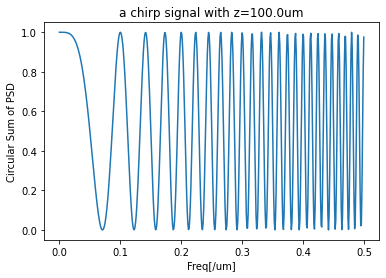

In [5]:
# Chirp model:

x = f_cpm[500:] # Setting the frequency scale axis of the chirp to match that of the signal.
chirp = lambda z_m, lambda_m, f_cpm: abs(np.cos(np.pi*z_m*lambda_m*f_cpm**2))**2 # Equation of chirp, which is used here to fit the signal!

z_m = 100e-6
lambda_m = 1e-6

plt.plot(f_cpm[500:] * 1e-6,chirp(z_m,lambda_m,f_cpm[500:]))
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.title('a chirp signal with z=%1.1fum'%(z_m*1e6))
plt.show() 

## Estimating reasonable parameters

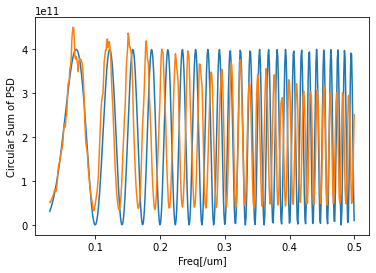

In [6]:
frange_cpm = f_cpm[530:]
chirp_opt = lambda X: X[1] * abs(np.sin(np.pi*X[0]*lambda_m*frange_cpm**2))**2 + X[2]

z_m = 100e-6 # Chirp frequency
a = 4e11 # Chirp amplitude
b= 8000  # Chirp offset

X0 = [z_m, a, b]

plt.plot(frange_cpm * 1e-6, chirp_opt(X0), frange_cpm * 1e-6, CIRCSUM[30:501])
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
#plt.title('a chirp signal with f0=%1.1f' %f0)
#plt.xlim((0, x[-1]))
plt.show()

## Fitting the data 

In [7]:
import scipy.optimize
cost_func = lambda X: np.sum(np.abs(CIRCSUM[30:501] - chirp_opt(X))**2)
X0 = [z_m, a, b]
X = scipy.optimize.fmin(cost_func, x0=X0)

## Evaluate goodness of fit

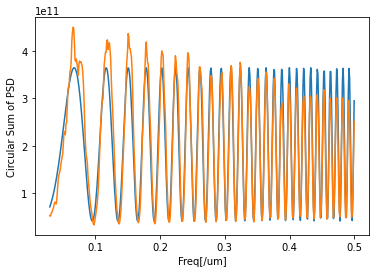

In [8]:
plt.plot(frange_cpm * 1e-6, chirp_opt(X), frange_cpm * 1e-6, CIRCSUM[30:501])
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
#plt.title('a chirp signal with f0=%1.1f' %f0)
#plt.xlim((0, x[-1]))
plt.show()

## All at once!

In [9]:
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
from skimage.transform import warp, warp_polar

zs_m = np.zeros(10)
img_nb = (np.arange(10)+1)
zt_m = (img_nb*10+100)*1e-6
for i_f in np.arange(10): 
    # parse filename
    filename = "supreme-15-%02.0f"%(i_f+1)+".png"
    filepath = folder + filename
    # read file
    img = np.asarray(Image.open(filepath))
    # Fourier Transform
    IMG = np.fft.fftshift(np.fft.fft2(img))
    # Circular sum
    CIRCSUM = np.sum(warp_polar(np.abs(IMG)**2), 0)
    # Data fitting
    cost_func = lambda X: np.sum(np.abs(CIRCSUM[30:501] - chirp_opt(X))**2)
    # initial guess for distance
    z_m= zt_m[i_f]
    X0 = [z_m, a, b]
    X = scipy.optimize.fmin(cost_func, x0=X0)
    # recovered distance
    zs_m[i_f] = X[0]

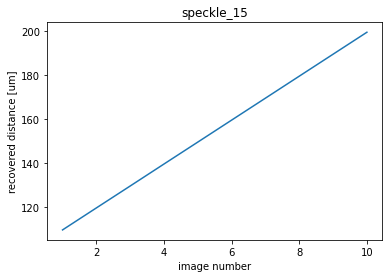

In [10]:
plt.plot(img_nb, zs_m*1e6)
plt.title('speckle_15')
plt.xlabel('image number')
plt.ylabel('recovered distance [um]')
plt.show()

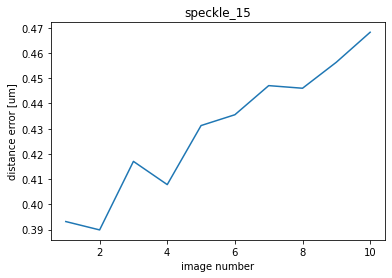

In [11]:
plt.plot(img_nb, (zt_m-zs_m)*1e6)
plt.title('speckle_15')
plt.xlabel('image number')
plt.ylabel('distance error [um]')
plt.show()

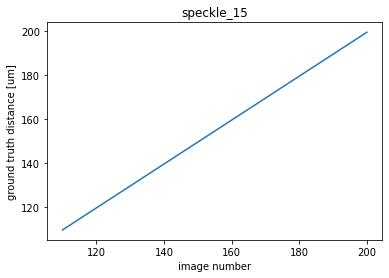

In [12]:
plt.plot(zt_m*1e6, zs_m*1e6)
plt.title('speckle_15')
plt.xlabel('image number')
plt.ylabel('ground truth distance [um]')
plt.show()